--- TIMELAPSE ANALYSIS ---
Video playback length @ 30p = 8.0 seconds
Total time paused = 99.8 minutes
Total light gathering time = 1 Hrs, 37 Mins
Total capture period = 3 Hrs, 17 Mins
----------------------------


       ARDUINO CODE FOR YOUR CONTROLLER
// --- COPY AND PASTE THESE LINES INTO YOUR ARDUINO SKETCH ---
// Automatically generated for 240 frames.
const unsigned long shutterListMS[] = {100, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 400, 400, 400, 400, 400, 400, 400, 400, 400, 500, 500, 500, 500, 500, 500, 500, 600, 600, 600, 600, 600, 600, 700, 700, 700, 700, 700, 800, 800, 800, 800, 900, 900, 900, 900, 1000, 1000, 1000, 1100, 1100, 1100, 1200, 1200, 1200, 1300, 1300, 1400, 1400, 1400, 1500, 1500, 1600, 1600, 1700, 1700, 1800, 1800, 1900, 2000, 2000, 2100, 2100, 2200, 2300, 2400, 2400, 2500, 2600, 2700, 2700, 2800, 2900, 3000, 3100, 3200, 3300,

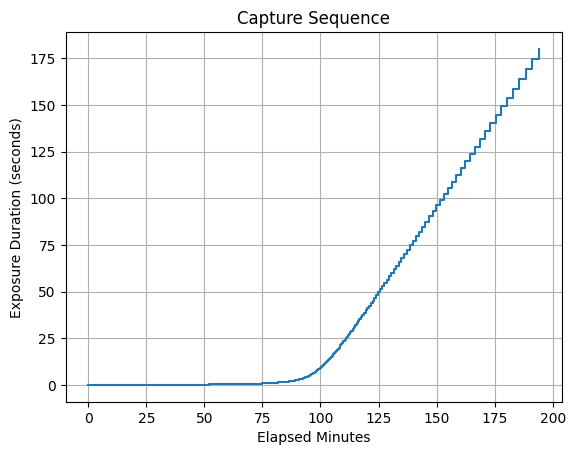

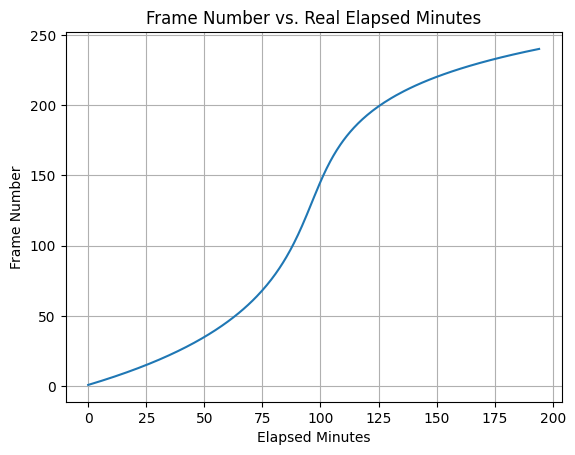

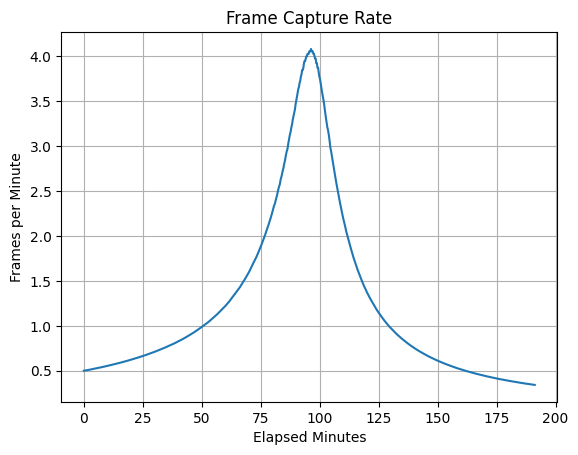

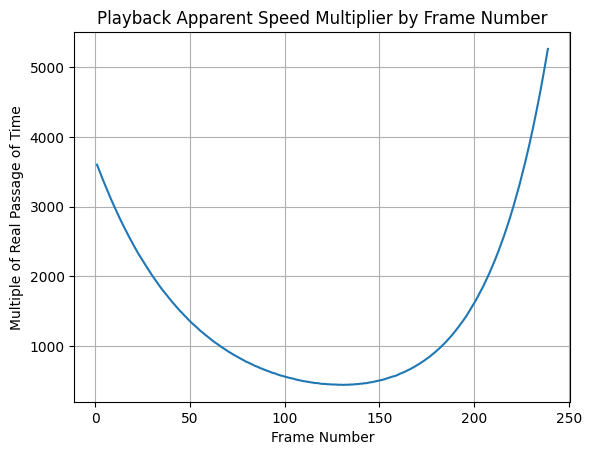

In [2]:
# -*- coding: utf-8 -*-
"""
Shutter Controller Calculator - Updated Version

This script calculates the non-linear shutter speeds and interval pauses
for a "holy grail" day-to-night timelapse sequence.

It now includes all original plots for analysis and a function to
automatically generate the C++ code required for the Arduino shutter controller.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ===================================================================
# FUNCTIONS AND CALCULATIONS
# ===================================================================

def times100(start_speed, end_speed, number_frames):
  """
  Generates a logarithmically spaced array of values and rounds them
  to the nearest 100. This is used for shutter speeds and pauses.
  """
  # Assumes inputs in milliseconds (ms)
  speeds = np.logspace(start=np.log(start_speed), stop=np.log(end_speed), num=number_frames, base=np.e)
  # Round up to the nearest 100 ms for practical exposure steps
  std_speeds = np.ceil((speeds - 1.0) / 100.0).astype(int) * 100
  return std_speeds

# --- Core Parameters ---
num_frames = 240

# --- Calculate Shutter and Pause Durations ---
# Shutter speeds increase from fast (day) to slow (night)
shutters = times100(100, 180000, num_frames)

# Pause times decrease as the light changes faster (sunset) and then level out
# Note: There is one less pause than there are shutters.
pauses = times100(120000, 1000, num_frames - 1)

# ===================================================================
# ANALYSIS AND PLOTTING
# ===================================================================

print("--- TIMELAPSE ANALYSIS ---")
print(f"Video playback length @ 30p = {round(num_frames/30, 1)} seconds")

total_time_paused_mins = round(np.sum(pauses) / 60000, 1)
print(f"Total time paused = {total_time_paused_mins} minutes")

total_rec_time_hrs = np.sum(shutters) / 3600000
rec_hrs = int(np.floor(total_rec_time_hrs))
rec_mins = int((total_rec_time_hrs - rec_hrs) * 60)
print(f"Total light gathering time = {rec_hrs} Hrs, {rec_mins} Mins")

total_capture_period_hrs = (np.sum(shutters) + np.sum(pauses)) / 1000 / 3600
cap_hrs = int(np.floor(total_capture_period_hrs))
cap_mins = int((total_capture_period_hrs - cap_hrs) * 60)
print(f"Total capture period = {cap_hrs} Hrs, {cap_mins} Mins")
print("-" * 28 + "\n")


# --- Plotting Calculations ---
# Calculate the start time for each frame in minutes
frames_start_mins = [0] + [(np.cumsum(shutters)[x] + np.cumsum(pauses)[x]) / 60000 for x in range(len(pauses))]

# Calculate the interval (duration from the start of one shot to the start of the next)
# This is needed for plots 3 and 4. The result is in seconds.
interval_seconds = np.diff(frames_start_mins) * 60

# --- Generate the 4 Plots ---

# Plot 1: Exposure time over the course of the timelapse
plt.figure(1)
plt.step(frames_start_mins, shutters / 1000, where='post') # Show shutter in seconds
plt.title("Capture Sequence")
plt.xlabel("Elapsed Minutes")
plt.ylabel("Exposure Duration (seconds)")
plt.grid(True)

# Plot 2: Frame number vs elapsed time
plt.figure(2)
plt.plot(frames_start_mins, np.arange(1, num_frames + 1))
plt.title("Frame Number vs. Real Elapsed Minutes")
plt.xlabel("Elapsed Minutes")
plt.ylabel("Frame Number")
plt.grid(True)

# Plot 3: Frame capture rate over time
plt.figure(3)
# The rate is frames per minute, which is 60 / interval in seconds
plt.plot(frames_start_mins[:-1], 60 / interval_seconds)
plt.title("Frame Capture Rate")
plt.xlabel("Elapsed Minutes")
plt.ylabel("Frames per Minute")
plt.grid(True)

# Plot 4: Apparent speed of the final video relative to real-time
plt.figure(4)
# The "multiple" is how many seconds of real time are compressed into one second of video (at 30fps)
# This is calculated as interval_seconds * frames_per_second (30)
playback_speed_multiplier = interval_seconds * 30 # Assuming 30fps playback
plt.plot(np.arange(1, num_frames), playback_speed_multiplier)
plt.title("Playback Apparent Speed Multiplier by Frame Number")
plt.xlabel("Frame Number")
plt.ylabel("Multiple of Real Passage of Time")
plt.grid(True)


# ===================================================================
# ARDUINO CODE GENERATION
# ===================================================================

def format_as_cpp_array(name, data_array):
  """
  Formats a numpy array into a C++ array declaration string.
  This function ensures the data type is correct (unsigned long) to
  prevent overflow on the Arduino.
  """
  # Convert array elements to strings and join them with ", "
  body = ", ".join(map(str, data_array))
  # Create the C++ array declaration using 'unsigned long' for large values
  return f"const unsigned long {name}[] = {{{body}}};"

# --- Generate the C++ code for both arrays ---
cpp_shutters = format_as_cpp_array("shutterListMS", shutters)
cpp_pauses = format_as_cpp_array("pauseListMS", pauses)

# --- Print the final, copy-paste ready block of code ---
print("\n" + "="*50)
print("       ARDUINO CODE FOR YOUR CONTROLLER")
print("="*50)
print("// --- COPY AND PASTE THESE LINES INTO YOUR ARDUINO SKETCH ---")
print(f"// Automatically generated for {num_frames} frames.")
print(cpp_shutters)
print(cpp_pauses)
print("// --- END OF ARDUINO CODE BLOCK ---")
print("="*50)

# Display all the generated plots
plt.show()